# fig_rq6_tpch_hudi

Plot TPCH RQ6 (Hudi only) results by order config and layout.


In [1]:
# --- Bootstrap paths so imports work both inside/outside VS Code ---
import sys
from pathlib import Path

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

NB_DIR = Path.cwd()           # current working dir (likely .../notebooks)
PROJ_ROOT = NB_DIR.parent     # project root (one level up)

for p in (NB_DIR, PROJ_ROOT):
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from viz_results_toolkit import savefig_multi, _resolve_extra_pdf_dir, _mirror_under_extra_dir

out_dir = PROJ_ROOT / "viz_out_results"
out_dir.mkdir(parents=True, exist_ok=True)


In [35]:
# --- Plotting constants and loader ---

from matplotlib.patches import Patch

LAYOUT_ORDER = ["no_layout", "linear", "zorder", "hilbert"]
LAYOUT_COLORS = {
    "no_layout": "#1f77b4",
    "linear": "#ff7f0e",
    "zorder": "#2ca02c",
    "hilbert": "#d62728",
}
ORDER_RE = re.compile(r"^lineitem_orders_(.+)$")
ORDER_LABEL_RE = re.compile(r"^L(?P<lidx>\d+)_O(?P<oidx>\d+)$")

# --- RQ6 plot typography (easy manual tuning) ---
RQ6_SUBPLOT_TITLE_FONTSIZE = 16
RQ6_XTICK_FONTSIZE = 12
RQ6_YLABEL_FONTSIZE = 16
RQ6_YTICK_FONTSIZE = 16
RQ6_LEGEND_FONTSIZE = 20


def _pick_no_layout_donor(order_label: str, available_no_layout_orders):
    """Prefer reusing the same O* baseline from L1-L3 for missing no_layout results."""
    candidates = set(available_no_layout_orders)
    m = ORDER_LABEL_RE.match(str(order_label))
    if m:
        oidx = m.group("oidx")
        for lidx in ("1", "2", "3"):
            cand = f"L{lidx}_O{oidx}"
            if cand in candidates and cand != order_label:
                return cand
        for cand in sorted(candidates):
            if cand.endswith(f"_O{oidx}") and cand != order_label:
                return cand
    for cand in sorted(candidates):
        if cand != order_label:
            return cand
    return None


def _backfill_missing_no_layout(df_all: pd.DataFrame, order_labels):
    no_layout_mask = df_all["layout"].astype(str) == "no_layout"
    available = set(df_all.loc[no_layout_mask, "order_label"].astype(str).unique())
    missing = [o for o in order_labels if o not in available]
    if not missing:
        return df_all

    extras = []
    for target in missing:
        donor = _pick_no_layout_donor(target, available)
        if donor is None:
            print(f"[rq6] WARN: cannot backfill no_layout for {target}: no donor found")
            continue
        donor_rows = df_all[(df_all["order_label"] == donor) & (df_all["layout"] == "no_layout")].copy()
        if donor_rows.empty:
            print(f"[rq6] WARN: donor {donor} has no no_layout rows")
            continue
        donor_rows["order_label"] = target
        donor_rows["no_layout_reused_from"] = donor
        extras.append(donor_rows)
        available.add(target)
        print(f"[rq6] backfilled no_layout for {target} from {donor} ({len(donor_rows)} rows)")

    if extras:
        df_all = pd.concat([df_all] + extras, ignore_index=True)
    return df_all


def _remap_rq6_order_label(order_label: str) -> str:
    """Fix label semantics: raw L4-L5 (1-col) -> L1-L2; raw L1-L3 (2-col) -> L3-L5."""
    label = str(order_label)
    m = ORDER_LABEL_RE.match(label)
    if not m:
        return label
    lidx = int(m.group("lidx"))
    oidx = m.group("oidx")
    if 1 <= lidx <= 3:
        new_lidx = lidx + 2
    elif 4 <= lidx <= 5:
        new_lidx = lidx - 3
    else:
        new_lidx = lidx
    return f"L{new_lidx}_O{oidx}"


def _rq6_order_label_sort_key(order_label: str):
    label = str(order_label)
    m = ORDER_LABEL_RE.match(label)
    if not m:
        return (10_000, 10_000, label)
    return (int(m.group("lidx")), int(m.group("oidx")), label)


def _remap_rq6_order_labels(df_all: pd.DataFrame, order_labels):
    d = df_all.copy()
    d["order_label"] = d["order_label"].astype(str).map(_remap_rq6_order_label)
    if "no_layout_reused_from" in d.columns:
        d["no_layout_reused_from"] = d["no_layout_reused_from"].map(
            lambda x: _remap_rq6_order_label(x) if pd.notna(x) else x
        )
    mapped_order_labels = [_remap_rq6_order_label(x) for x in order_labels]
    mapped_order_labels = sorted(dict.fromkeys(mapped_order_labels), key=_rq6_order_label_sort_key)
    return d, mapped_order_labels


def _normalize_layout_order_arg(layout_order):
    if layout_order is None:
        return None
    if isinstance(layout_order, str):
        tokens = re.split(r"[,\s]+", layout_order.strip())
        return [t for t in tokens if t]
    return [str(x) for x in layout_order if str(x)]


def _normalize_order_order_arg(order_order):
    if order_order is None:
        return None
    if isinstance(order_order, str):
        tokens = re.split(r"[,\s]+", order_order.strip())
        tokens = [t for t in tokens if t]
    else:
        tokens = [str(x) for x in order_order if str(x)]
    normalized = []
    for t in tokens:
        normalized.append(t.replace("lineitem_orders_", ""))
    return normalized


def _normalize_query_order_arg(query_order):
    if query_order is None:
        return None
    if isinstance(query_order, str):
        tokens = re.split(r"[,\s]+", query_order.strip())
        tokens = [t for t in tokens if t]
    else:
        tokens = [str(x) for x in query_order if str(x)]
    normalized = []
    for t in tokens:
        q = str(t).strip()
        if q.lower().endswith('.sql'):
            q = q[:-4]
        normalized.append(q)
    return normalized


def resolve_layout_order(per_stream: pd.DataFrame, layout_order=None):
    """Use preferred order first, then append any newly added layouts found in data."""
    manual = _normalize_layout_order_arg(layout_order)
    if manual is not None:
        return manual
    seen = [str(x) for x in per_stream["layout"].dropna().unique().tolist()]
    preferred = [x for x in LAYOUT_ORDER if x in seen]
    extras = sorted(x for x in seen if x not in preferred)
    return preferred + extras


def load_rq6_results(root_dir: Path):
    frames = []
    order_labels = []
    for order_dir in sorted(p for p in root_dir.iterdir() if p.is_dir()):
        match = ORDER_RE.match(order_dir.name)
        order_label = match.group(1) if match else order_dir.name
        if order_label not in order_labels:
            order_labels.append(order_label)
        for layout_dir in sorted(p for p in order_dir.iterdir() if p.is_dir()):
            layout = layout_dir.name
            engine_dir = layout_dir / "hudi"
            if not engine_dir.is_dir():
                continue
            for stream_dir in sorted(engine_dir.glob("stream_*")):
                ts_dirs = sorted(p for p in stream_dir.iterdir() if p.is_dir())
                if not ts_dirs:
                    continue
                latest = ts_dirs[-1]
                csv_path = latest / "results.csv"
                if not csv_path.exists():
                    continue
                df = pd.read_csv(csv_path)
                df["order_label"] = order_label
                df["layout"] = layout
                df["stream"] = stream_dir.name
                df["timestamp"] = latest.name
                frames.append(df)
    if not frames:
        raise FileNotFoundError(f"No RQ6 CSVs found under {root_dir}")
    df_all = pd.concat(frames, ignore_index=True)
    df_all["query_id"] = df_all["query"].astype(str).str.replace(".sql", "", regex=False)
    df_all = _backfill_missing_no_layout(df_all, order_labels)
    df_all, order_labels = _remap_rq6_order_labels(df_all, order_labels)
    return df_all, order_labels


def prepare_rq6_stream_values(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    df = df.copy()
    df[metric] = pd.to_numeric(df[metric], errors="coerce")
    df = df.dropna(subset=[metric])
    per_stream = (
        df.groupby(["order_label", "layout", "query_id", "stream"], as_index=False)[metric]
        .mean()
    )
    return per_stream


def plot_rq6_query_grid(
    per_stream: pd.DataFrame,
    *,
    metric: str,
    layout_order=None,
    order_order=None,
    query_order=None,
    ncols=3,
    log_y=False,
    save=True,
    save_dir=None,
    filename_prefix=None,
    filename=None,
    save_formats=("png", "pdf"),
):
    manual_layout_order = _normalize_layout_order_arg(layout_order)
    layout_order = resolve_layout_order(per_stream, manual_layout_order)
    if manual_layout_order is not None:
        missing_layouts = [x for x in layout_order if x not in set(per_stream["layout"].astype(str).unique())]
        if missing_layouts:
            print(f"[rq6] WARN: requested layouts not found in data: {missing_layouts}")
        per_stream = per_stream[per_stream["layout"].astype(str).isin(layout_order)].copy()
        if per_stream.empty:
            raise ValueError("No rows remain after applying manual layout_order filter")
    manual_order_order = _normalize_order_order_arg(order_order)
    if manual_order_order is not None:
        seen_orders = set(per_stream["order_label"].astype(str).unique())
        missing_orders = [x for x in manual_order_order if x not in seen_orders]
        if missing_orders:
            print(f"[rq6] WARN: requested order labels not found in data: {missing_orders}")
        per_stream = per_stream[per_stream["order_label"].astype(str).isin(manual_order_order)].copy()
        if per_stream.empty:
            raise ValueError("No rows remain after applying manual order_order filter")
        order_order = [x for x in manual_order_order if x in set(per_stream["order_label"].astype(str).unique())]
    else:
        order_order = sorted(per_stream["order_label"].unique())
    manual_query_order = _normalize_query_order_arg(query_order)
    if manual_query_order is not None:
        seen_queries = set(per_stream["query_id"].astype(str).unique())
        missing_queries = [x for x in manual_query_order if x not in seen_queries]
        if missing_queries:
            print(f"[rq6] WARN: requested queries not found in data: {missing_queries}")
        per_stream = per_stream[per_stream["query_id"].astype(str).isin(manual_query_order)].copy()
        if per_stream.empty:
            raise ValueError("No rows remain after applying manual query_order filter")
        queries = [x for x in manual_query_order if x in set(per_stream["query_id"].astype(str).unique())]
    else:
        queries = sorted(per_stream["query_id"].unique())
    n = len(queries)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 4 * nrows), squeeze=False)
    legend_handles = []
    seen_labels = set()

    for idx, query_id in enumerate(queries):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        dfq = per_stream[per_stream["query_id"] == query_id]
        x = np.arange(len(order_order))
        box_width = min(0.8 / max(1, len(layout_order)), 0.25)
        offsets = [(i - (len(layout_order) - 1) / 2) * box_width for i in range(len(layout_order))]

        for offset, layout in zip(offsets, layout_order):
            data = []
            for order_label in order_order:
                subset = dfq[(dfq["order_label"] == order_label) & (dfq["layout"] == layout)]
                vals = subset[metric].tolist()
                if log_y:
                    vals = [v for v in vals if pd.notna(v) and v > 0]
                if not vals:
                    vals = [np.nan]
                data.append(vals)
            positions = x + offset
            bp = ax.boxplot(
                data,
                positions=positions,
                widths=box_width,
                patch_artist=True,
                manage_ticks=False,
                showfliers=False,
            )
            color = LAYOUT_COLORS.get(layout, "#888888")
            for patch in bp["boxes"]:
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            for median in bp["medians"]:
                median.set_color("#222222")

            if layout not in seen_labels:
                legend_handles.append(Patch(facecolor=color, edgecolor="#333333", label=layout, alpha=0.6))
                seen_labels.add(layout)

        ax.set_title(query_id, fontsize=RQ6_SUBPLOT_TITLE_FONTSIZE)
        ax.set_xticks(x)
        ax.set_xticklabels(order_order, rotation=15, ha='center', rotation_mode='anchor', fontsize=RQ6_XTICK_FONTSIZE)
        ax.set_xlim(-0.5, len(order_order) - 0.5)
        ax.set_ylabel(metric, fontsize=RQ6_YLABEL_FONTSIZE)
        ax.tick_params(axis='y', labelsize=RQ6_YTICK_FONTSIZE)
        if log_y:
            ax.set_yscale('log')
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    for k in range(n, nrows * ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis('off')

    if legend_handles:
        fig.legend(
            legend_handles,
            [h.get_label() for h in legend_handles],
            loc='upper center',
            bbox_to_anchor=(0.5, 1.0505),
            ncol=len(legend_handles),
            frameon=False,
            fontsize=RQ6_LEGEND_FONTSIZE,
        )

    fig.tight_layout(rect=(0, 0, 1, 0.93))
    if save:
        base_dir = Path(save_dir) if save_dir else out_dir
        base_dir.mkdir(parents=True, exist_ok=True)
        default_prefix = f"rq6_tpch_hudi_{metric}"
        stem_value = filename or filename_prefix or default_prefix
        stem_path = Path(str(stem_value))
        base_name = stem_path.stem if stem_path.suffix else stem_path.name
        # fmt_list = [stem_path.suffix.lstrip('.')] if stem_path.suffix else save_formats
        fmt_list = save_formats
        if isinstance(fmt_list, str):
            fmt_list = [fmt_list]
        saved_paths = []
        extra_pdf_dir = _resolve_extra_pdf_dir(None)
        
        for fmt in fmt_list:
            ext = fmt.lstrip('.').lower()
            print(ext)
            if ext == 'pdf' and extra_pdf_dir is not None:
                out_path = _mirror_under_extra_dir(base_dir / base_name, extra_pdf_dir).with_suffix('.pdf')
            else:
                out_path = base_dir / f"{base_name}.{ext}"
            saved_paths.append(out_path)
        savefig_multi(fig, base_dir / base_name, fmts=fmt_list, extra_pdf_dir=extra_pdf_dir)
        print("saved:", ", ".join(str(p) for p in saved_paths))
    return fig


[rq6] backfilled no_layout for L4_O2 from L1_O2 (200 rows)
[rq6] backfilled no_layout for L4_O3 from L1_O3 (200 rows)
[rq6] backfilled no_layout for L5_O1 from L1_O1 (200 rows)
[rq6] backfilled no_layout for L5_O2 from L1_O2 (200 rows)
[rq6] backfilled no_layout for L5_O3 from L1_O3 (200 rows)
png
pdf
saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq6_tpch_hudi_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/应用/Overleaf/When and How to Use Space-Filling Curves for Lakehouse Layout Optimization/exp/rq6_tpch_hudi_bytes_scanned_ev.pdf
png
pdf
saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/all.png, /Users/guanlil1/Dropbox/应用/Overleaf/When and How to Use Space-Filling Curves for Lakehouse Layout Optimization/exp/all.pdf


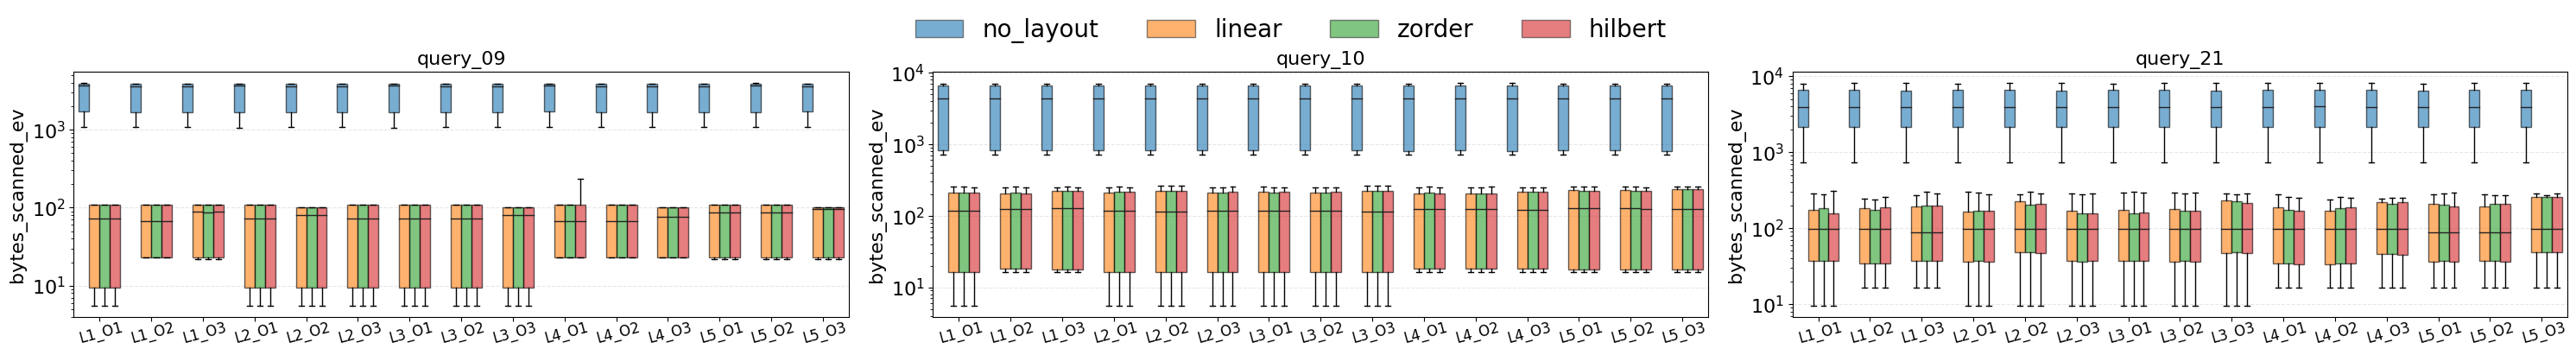

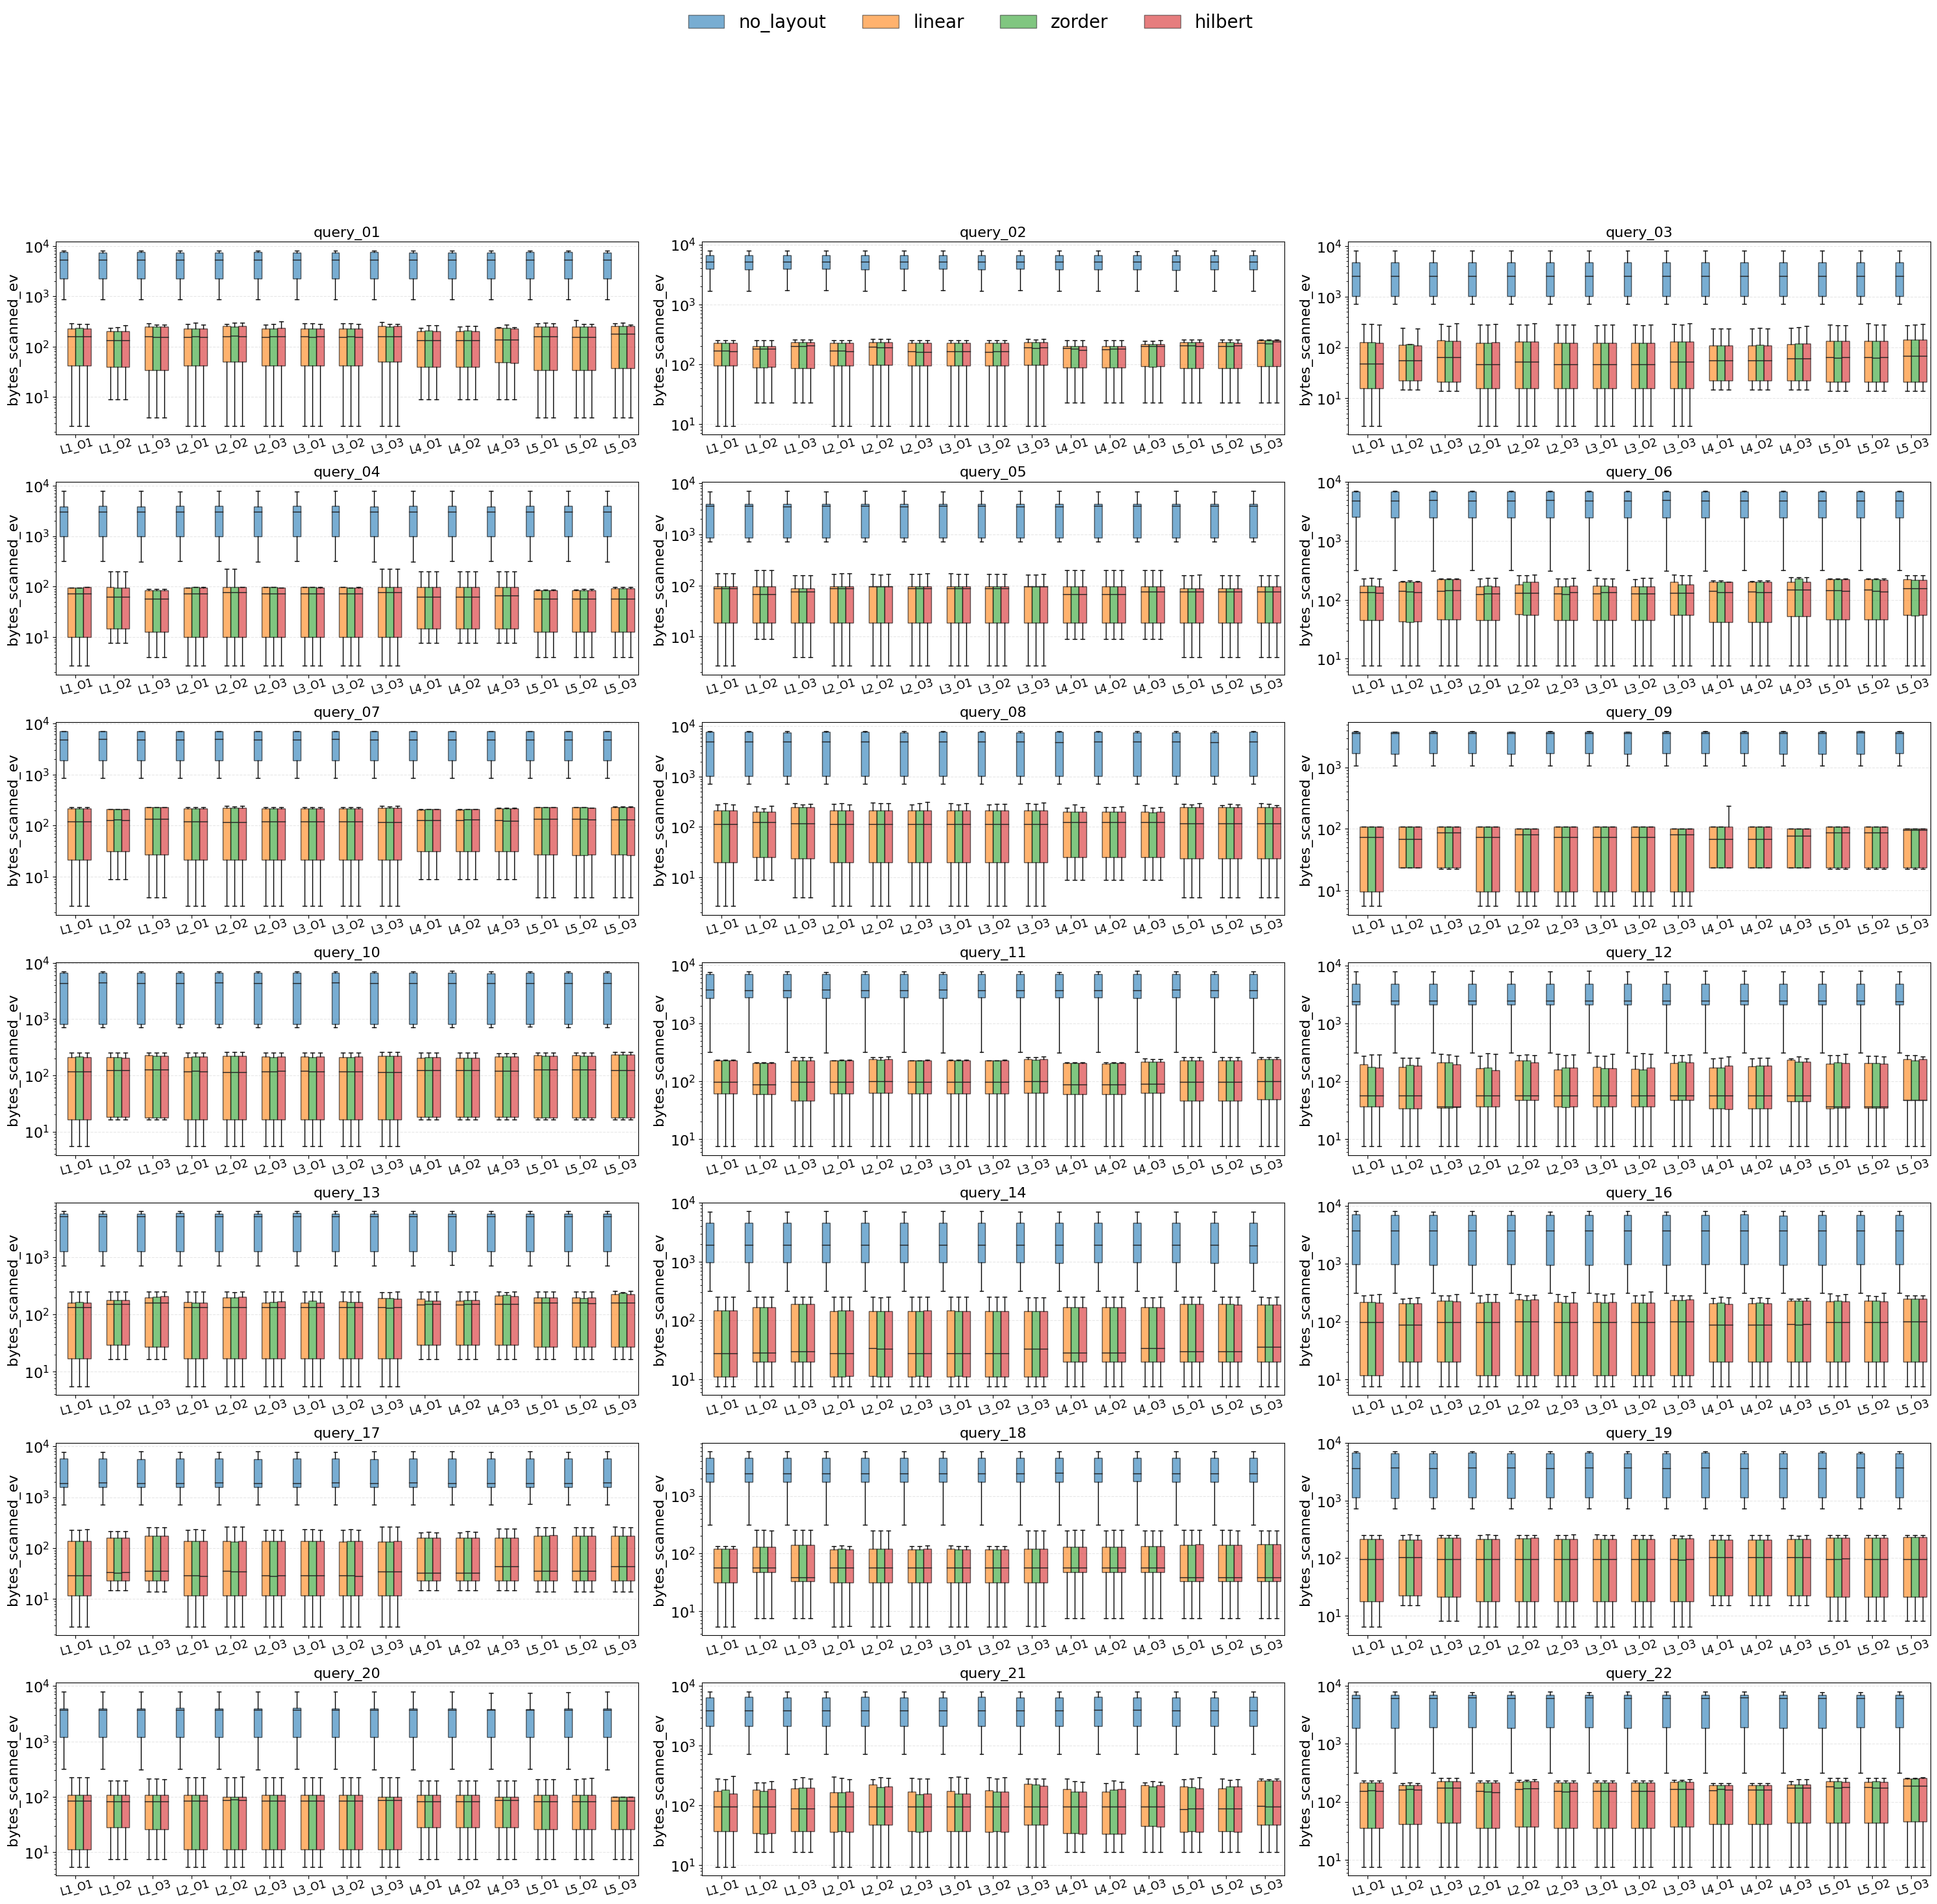

In [36]:
# Example usage: adjust metric as needed
rq6_root = PROJ_ROOT / "results" / "RQ6" / "tpch_rq6_hudi"
df_raw, order_labels = load_rq6_results(rq6_root)

metric = "bytes_scanned_ev"
LOG_Y = True
MANUAL_LAYOUT_ORDER = None  # e.g. ["no_layout", "zorder", "hilbert"] or "no_layout,zorder"
MANUAL_ORDER_ORDER = None  # e.g. "L1_O1" or ["L1_O1", "L2_O1"]
# MANUAL_QUERY_ORDER = None  # e.g. "Q1" or ["Q1", "Q6", "Q14"]
MANUAL_QUERY_ORDER = ["query_09", "query_10", "query_21"]
# MANUAL_ORDER_ORDER =["L1_O1", "L1_O2", "L1_O3", "L2_O1", "L2_O2", "L2_O3"]
per_stream = prepare_rq6_stream_values(df_raw, metric)

fig = plot_rq6_query_grid(
    per_stream,
    metric=metric,
    layout_order=MANUAL_LAYOUT_ORDER,
    order_order=(MANUAL_ORDER_ORDER or order_labels),
    query_order=MANUAL_QUERY_ORDER,
    log_y=LOG_Y,
)
MANUAL_QUERY_ORDER = None  # e.g. "Q1" or ["Q1", "Q6", "Q14"]

fig = plot_rq6_query_grid(
    per_stream,
    metric=metric,
    layout_order=MANUAL_LAYOUT_ORDER,
    order_order=(MANUAL_ORDER_ORDER or order_labels),
    query_order=MANUAL_QUERY_ORDER,
    log_y=LOG_Y,
    # save=False,
    filename_prefix="all"
)


In [4]:
# # Example usage: adjust metric as needed
# rq6_root = PROJ_ROOT / "results" / "RQ6" / "tpch_rq6_hudi"
# df_raw, order_labels = load_rq6_results(rq6_root)

# metric = "files_scanned"
# LOG_Y = True
# MANUAL_LAYOUT_ORDER = None  # e.g. ["no_layout", "zorder"]
# MANUAL_ORDER_ORDER = None  # e.g. "L1_O1" or ["L1_O1", "L2_O1"]
# MANUAL_QUERY_ORDER = None  # e.g. "Q1" or ["Q1", "Q6", "Q14"]
# per_stream = prepare_rq6_stream_values(df_raw, metric)

# fig = plot_rq6_query_grid(
#     per_stream,
#     metric=metric,
#     layout_order=MANUAL_LAYOUT_ORDER,
#     order_order=(MANUAL_ORDER_ORDER or order_labels),
#     query_order=MANUAL_QUERY_ORDER,
#     log_y=LOG_Y,
# )

[rq6] backfilled no_layout for L4_O2 from L1_O2 (200 rows)
[rq6] backfilled no_layout for L4_O3 from L1_O3 (200 rows)
[rq6] backfilled no_layout for L5_O1 from L1_O1 (200 rows)
[rq6] backfilled no_layout for L5_O2 from L1_O2 (200 rows)
[rq6] backfilled no_layout for L5_O3 from L1_O3 (200 rows)
saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq6_tpch_hudi_executorCpuTime_s_ev.png, /Users/guanlil1/Dropbox/应用/Overleaf/When and How to Use Space-Filling Curves for Lakehouse Layout Optimization/exp/rq6_tpch_hudi_executorCpuTime_s_ev.pdf
saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/all.png, /Users/guanlil1/Dropbox/应用/Overleaf/When and How to Use Space-Filling Curves for Lakehouse Layout Optimization/exp/all.pdf


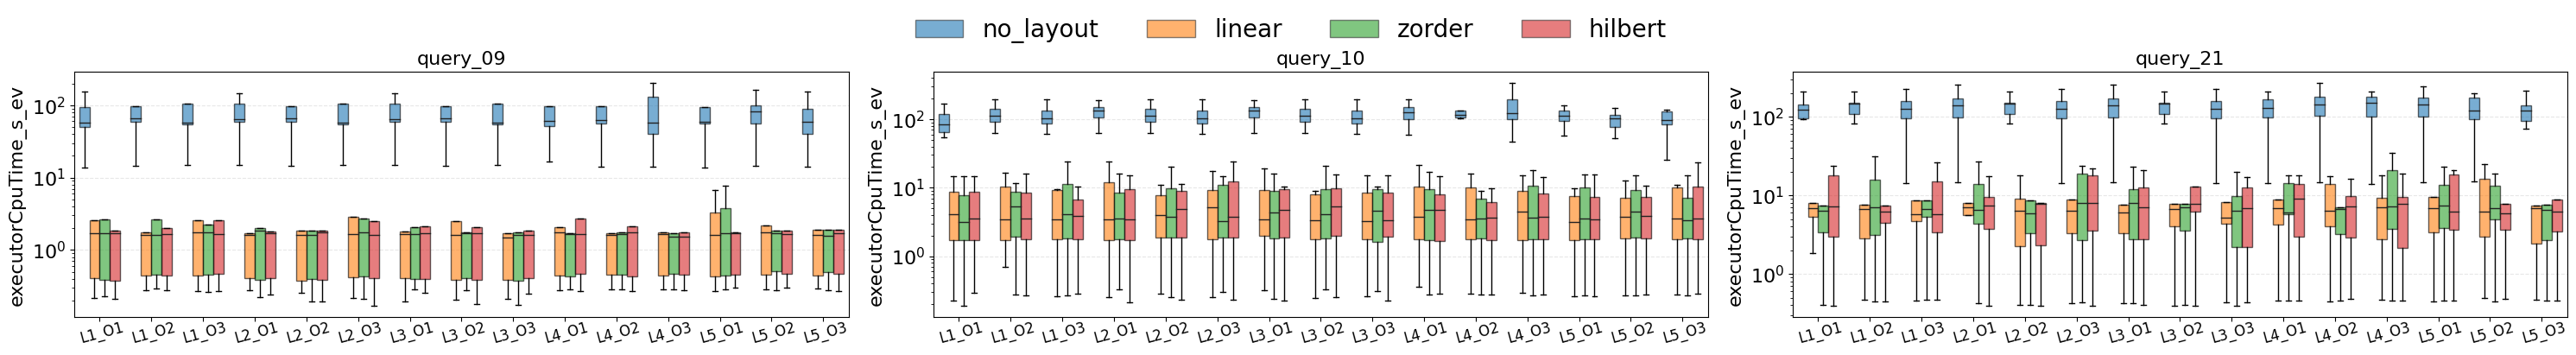

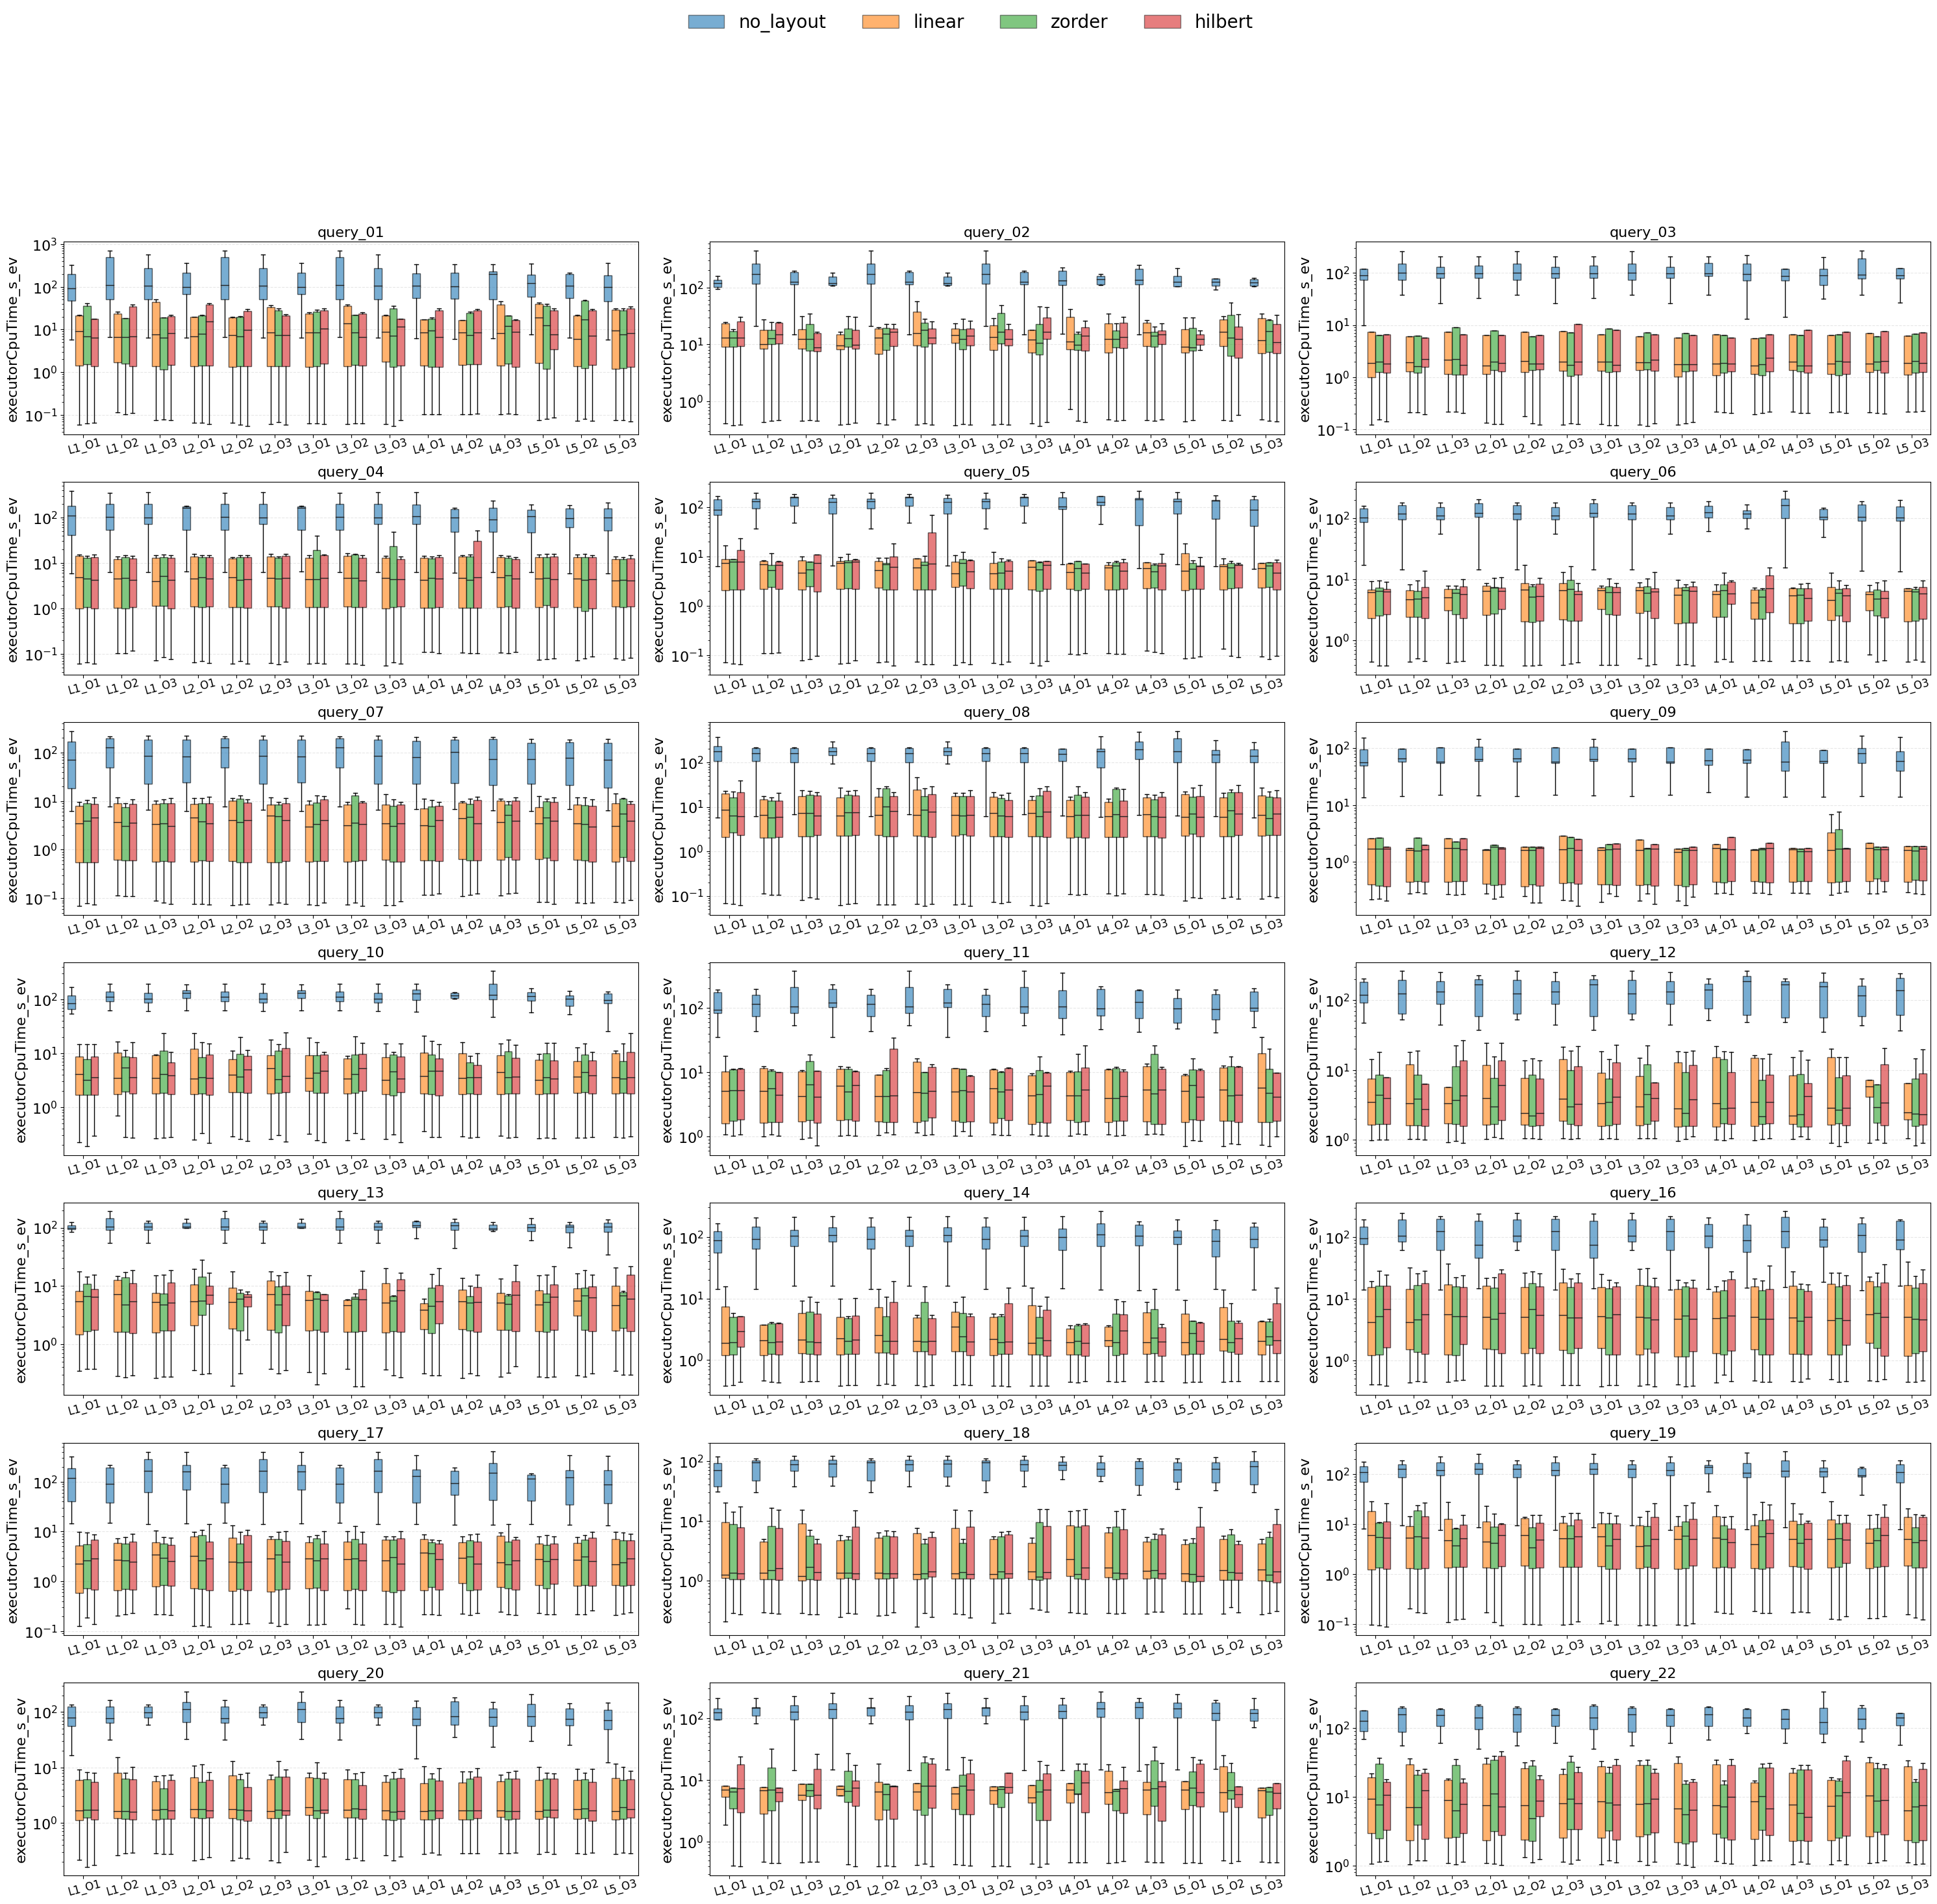

In [33]:
rq6_root = PROJ_ROOT / "results" / "RQ6" / "tpch_rq6_hudi"
df_raw, order_labels = load_rq6_results(rq6_root)

metric = "executorCpuTime_s_ev"
# metric = "elapsedTime_s"

LOG_Y = True
MANUAL_LAYOUT_ORDER = None  # e.g. ["no_layout", "zorder", "hilbert"] or "no_layout,zorder"
MANUAL_ORDER_ORDER = None  # e.g. "L1_O1" or ["L1_O1", "L2_O1"]
MANUAL_QUERY_ORDER = None  # e.g. "Q1" or ["Q1", "Q6", "Q14"]
per_stream = prepare_rq6_stream_values(df_raw, metric)

MANUAL_QUERY_ORDER = ["query_09", "query_10", "query_21"]

fig = plot_rq6_query_grid(
    per_stream,
    metric=metric,
    layout_order=MANUAL_LAYOUT_ORDER,
    order_order=(MANUAL_ORDER_ORDER or order_labels),
    query_order=MANUAL_QUERY_ORDER,
    log_y=LOG_Y,
)

MANUAL_QUERY_ORDER = None  # e.g. "Q1" or ["Q1", "Q6", "Q14"]
fig = plot_rq6_query_grid(
    per_stream,
    metric=metric,
    layout_order=MANUAL_LAYOUT_ORDER,
    order_order=(MANUAL_ORDER_ORDER or order_labels),
    query_order=MANUAL_QUERY_ORDER,
    log_y=LOG_Y,
    # save=False,
    filename_prefix="all"
)
